In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import iforest
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

#load the data
games = pd.read_csv('data/games.csv')
bot = pd.read_csv('data/bot_games.csv')
test = pd.read_csv('data/test.csv')

In [19]:
# generate features for the data
# We want to compile the match info into fields that are specific to the winning or losing team
# this will make more sense to the model

def get_features(row):
    fields = ['gold_per_min', 'hero_damage', 'kda', 'kills', 'last_hits', 'level', 'xp_per_min','deaths']
    features = []
    radi = []
    for plyr in range(1,6):
        hdr_pfx = 'P'+str(plyr)+'_'
        plyrstats = row[[hdr_pfx + x for x in fields]].tolist()
        radi.append(plyrstats)
    radi = pd.DataFrame(radi, columns = fields)
    radi_desc = radi.describe()
    if(row['radiant_win']):
        tag_R = 'WIN'
        tag_D = 'LOSE'
    else:
        tag_R ='LOSE'
        tag_D = 'WIN'
    for measure in ['mean', 'std']:
        radi_ = radi_desc.loc[measure]
        radi_.index = [tag_R+x+'_'+measure for x in fields]
        radi_.columns = [0]
        features.append(radi_)
    dire = []
    for plyr in range(6,11):
        hdr_pfx = 'P'+str(plyr)+'_'
        plyrstats = row[[hdr_pfx + x for x in fields]].tolist()
        dire.append(plyrstats)
    dire = pd.DataFrame(dire, columns=fields)
    dire_desc = dire.describe()
    for measure in ['mean', 'std']:
        dire_ = dire_desc.loc[measure]
        dire_.index = [tag_D+x+'_'+measure for x in fields]
        dire_.columns = [0]
        features.append(dire_)
    return pd.concat(features,0)

In [20]:
games_plus = pd.concat([games,games.apply(get_features, 1).reset_index(drop=True)], 1)
bot_plus = pd.concat([bot, bot.apply(get_features,1).reset_index(drop=True)], 1)
test = pd.concat([test, test.apply(get_features,1).reset_index(drop=True)], 1)

In [21]:
# we keep only the features we generated + some others from the vanilla dataset
keep = ['radiant_win', 'radiant_score', 'dire_score', 'first_blood_time',
 'duration','LOSEdeaths_mean', 'LOSEdeaths_std', 'LOSEgold_per_min_mean',
 'LOSEgold_per_min_std', 'LOSEhero_damage_mean', 'LOSEhero_damage_std',
 'LOSEkda_mean', 'LOSEkda_std', 'LOSEkills_mean', 'LOSEkills_std',
 'LOSElast_hits_mean', 'LOSElast_hits_std', 'LOSElevel_mean', 'LOSElevel_std',
 'LOSExp_per_min_mean', 'LOSExp_per_min_std', 'WINdeaths_mean', 'WINdeaths_std',
 'WINgold_per_min_mean', 'WINgold_per_min_std', 'WINhero_damage_mean',
 'WINhero_damage_std', 'WINkda_mean', 'WINkda_std', 'WINkills_mean',
 'WINkills_std', 'WINlast_hits_mean', 'WINlast_hits_std', 'WINlevel_mean',
 'WINlevel_std', 'WINxp_per_min_mean', 'WINxp_per_min_std']
test = test[keep]
bot_plus = bot_plus[keep]
games_plus = games_plus[keep]

In [22]:
len(dataArray)

5879

# iforest

In [23]:
# building the iforest from the training data
dataArray = np.array(games_plus.dropna().astype(np.float32))

forest = iforest.IsolationForest(max_samples = 0.2, 
                                 max_features=len(data.columns),
                                 n_estimators = 1000,
                                 n_jobs = 1, 
                                 verbose = 1)
forest.fit(dataArray)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.5s finished


IsolationForest(bootstrap=False, max_features=37, max_samples=0.2,
        n_estimators=1000, n_jobs=1, random_state=None, verbose=1)

In [24]:
# labelling the test dataset & testing the forest on it 
bot_plus_ = bot_plus.dropna()
bot_plus_['is_bot'] = 1
test['is_bot'] = 0
test_set = pd.concat([bot_plus_, test])

C:\Users\chenzhiling\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [25]:
arraytest = np.array(test_set.drop(['is_bot'], 1).astype(np.float32))
test_set['pred'] = forest.predict(arraytest)

In [26]:
test_set

,radiant_win,radiant_score,dire_score,first_blood_time,duration,LOSEdeaths_mean,LOSEdeaths_std,LOSEgold_per_min_mean,LOSEgold_per_min_std,LOSEhero_damage_mean,...,WINkills_mean,WINkills_std,WINlast_hits_mean,WINlast_hits_std,WINlevel_mean,WINlevel_std,WINxp_per_min_mean,WINxp_per_min_std,is_bot,pred
0,False,0,10,149,369,2.0,0.000000,103.4,6.188699,0.0,...,1.0,1.000000,7.2,3.033150,3.0,0.000000,125.0,14.035669,1,0.634867
1,True,6,1,125,370,1.2,0.447214,147.2,16.238842,0.0,...,1.0,0.707107,6.8,2.774887,2.8,0.447214,111.0,11.180340,1,0.630128
2,True,30,5,89,684,6.0,2.236068,185.8,104.647981,586.6,...,5.8,12.417729,21.2,28.402465,5.0,4.472136,210.2,298.430394,1,0.600234
3,False,4,42,34,635,8.4,2.509980,139.2,110.014544,893.2,...,8.0,17.334936,16.0,22.638463,4.6,5.813777,238.0,424.852916,1,0.633404
4,False,2,10,139,407,2.0,0.000000,105.8,8.318654,0.0,...,1.8,1.483240,9.2,5.540758,3.2,0.447214,147.2,15.959323,1,0.627012
5,False,2,10,121,377,2.0,0.000000,105.2,7.563068,4.8,...,1.4,1.140175,6.2,3.420526,3.0,0.000000,127.0,22.304708,1,0.630486
6,False,2,27,0,373,5.4,5.941380,156.8,52.342144,315.4,...,4.0,1.870829,6.4,2.073644,4.0,0.000000,202.6,15.565989,1,0.631338
7,False,0,11,126,373,2.2,0.447214,98.4,5.412947,28.8,...,1.2,1.788854,9.0,4.242641,3.0,0.000000,119.2,15.482248,1,0.631539
121,True,57,64,48,3269,11.4,25.491175,205.8,51.183005,9135.2,...,11.4,9.555103,38.0,25.573424,13.0,4.472136,161.0,73.813955,1,0.665924
122,True,60,63,31,3291,12.0,26.832816,203.6,48.557183,7234.8,...,11.4,7.700649,41.8,23.445682,13.0,4.472136,160.2,73.916845,1,0.665409


In [13]:
# genera
fpr, tpr, _ = roc_curve(np.array(test_set['is_bot']), np.array(test_set['pred']), drop_intermediate = False)
auc = auc(fpr, tpr)
print "AUC: %d"%auc

plt.plot(fpr, tpr, marker = 'o')
plt.show()

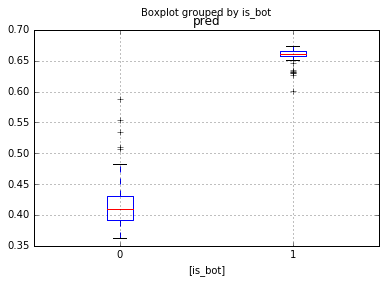

In [27]:
test_set[['is_bot','pred']].boxplot(by='is_bot')